In [370]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

In [371]:
df = pd.read_csv('Womens_Reviews.csv')

In [372]:
df.head

<bound method NDFrame.head of        Unnamed: 0  Clothing ID  Age  \
0               0          767   33   
1               1         1080   34   
2               2         1077   60   
3               3         1049   50   
4               4          847   47   
...           ...          ...  ...   
23481       23481         1104   34   
23482       23482          862   48   
23483       23483         1104   31   
23484       23484         1084   28   
23485       23485         1104   52   

                                                   Title  \
0                                                    NaN   
1                                                    NaN   
2                                Some major design flaws   
3                                       My favorite buy!   
4                                       Flattering shirt   
...                                                  ...   
23481                     Great dress for many occasions   
23482                

## data visualization

<AxesSubplot: xlabel='Rating', ylabel='Class Name'>

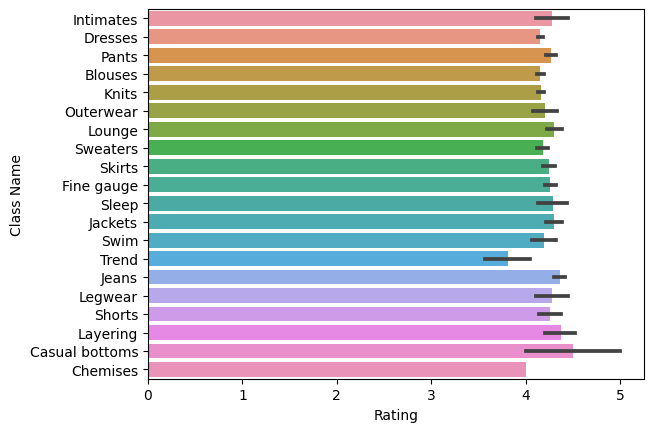

In [373]:
#ratings by clothing category 
sns.barplot(x='Rating', y='Class Name', data=df)


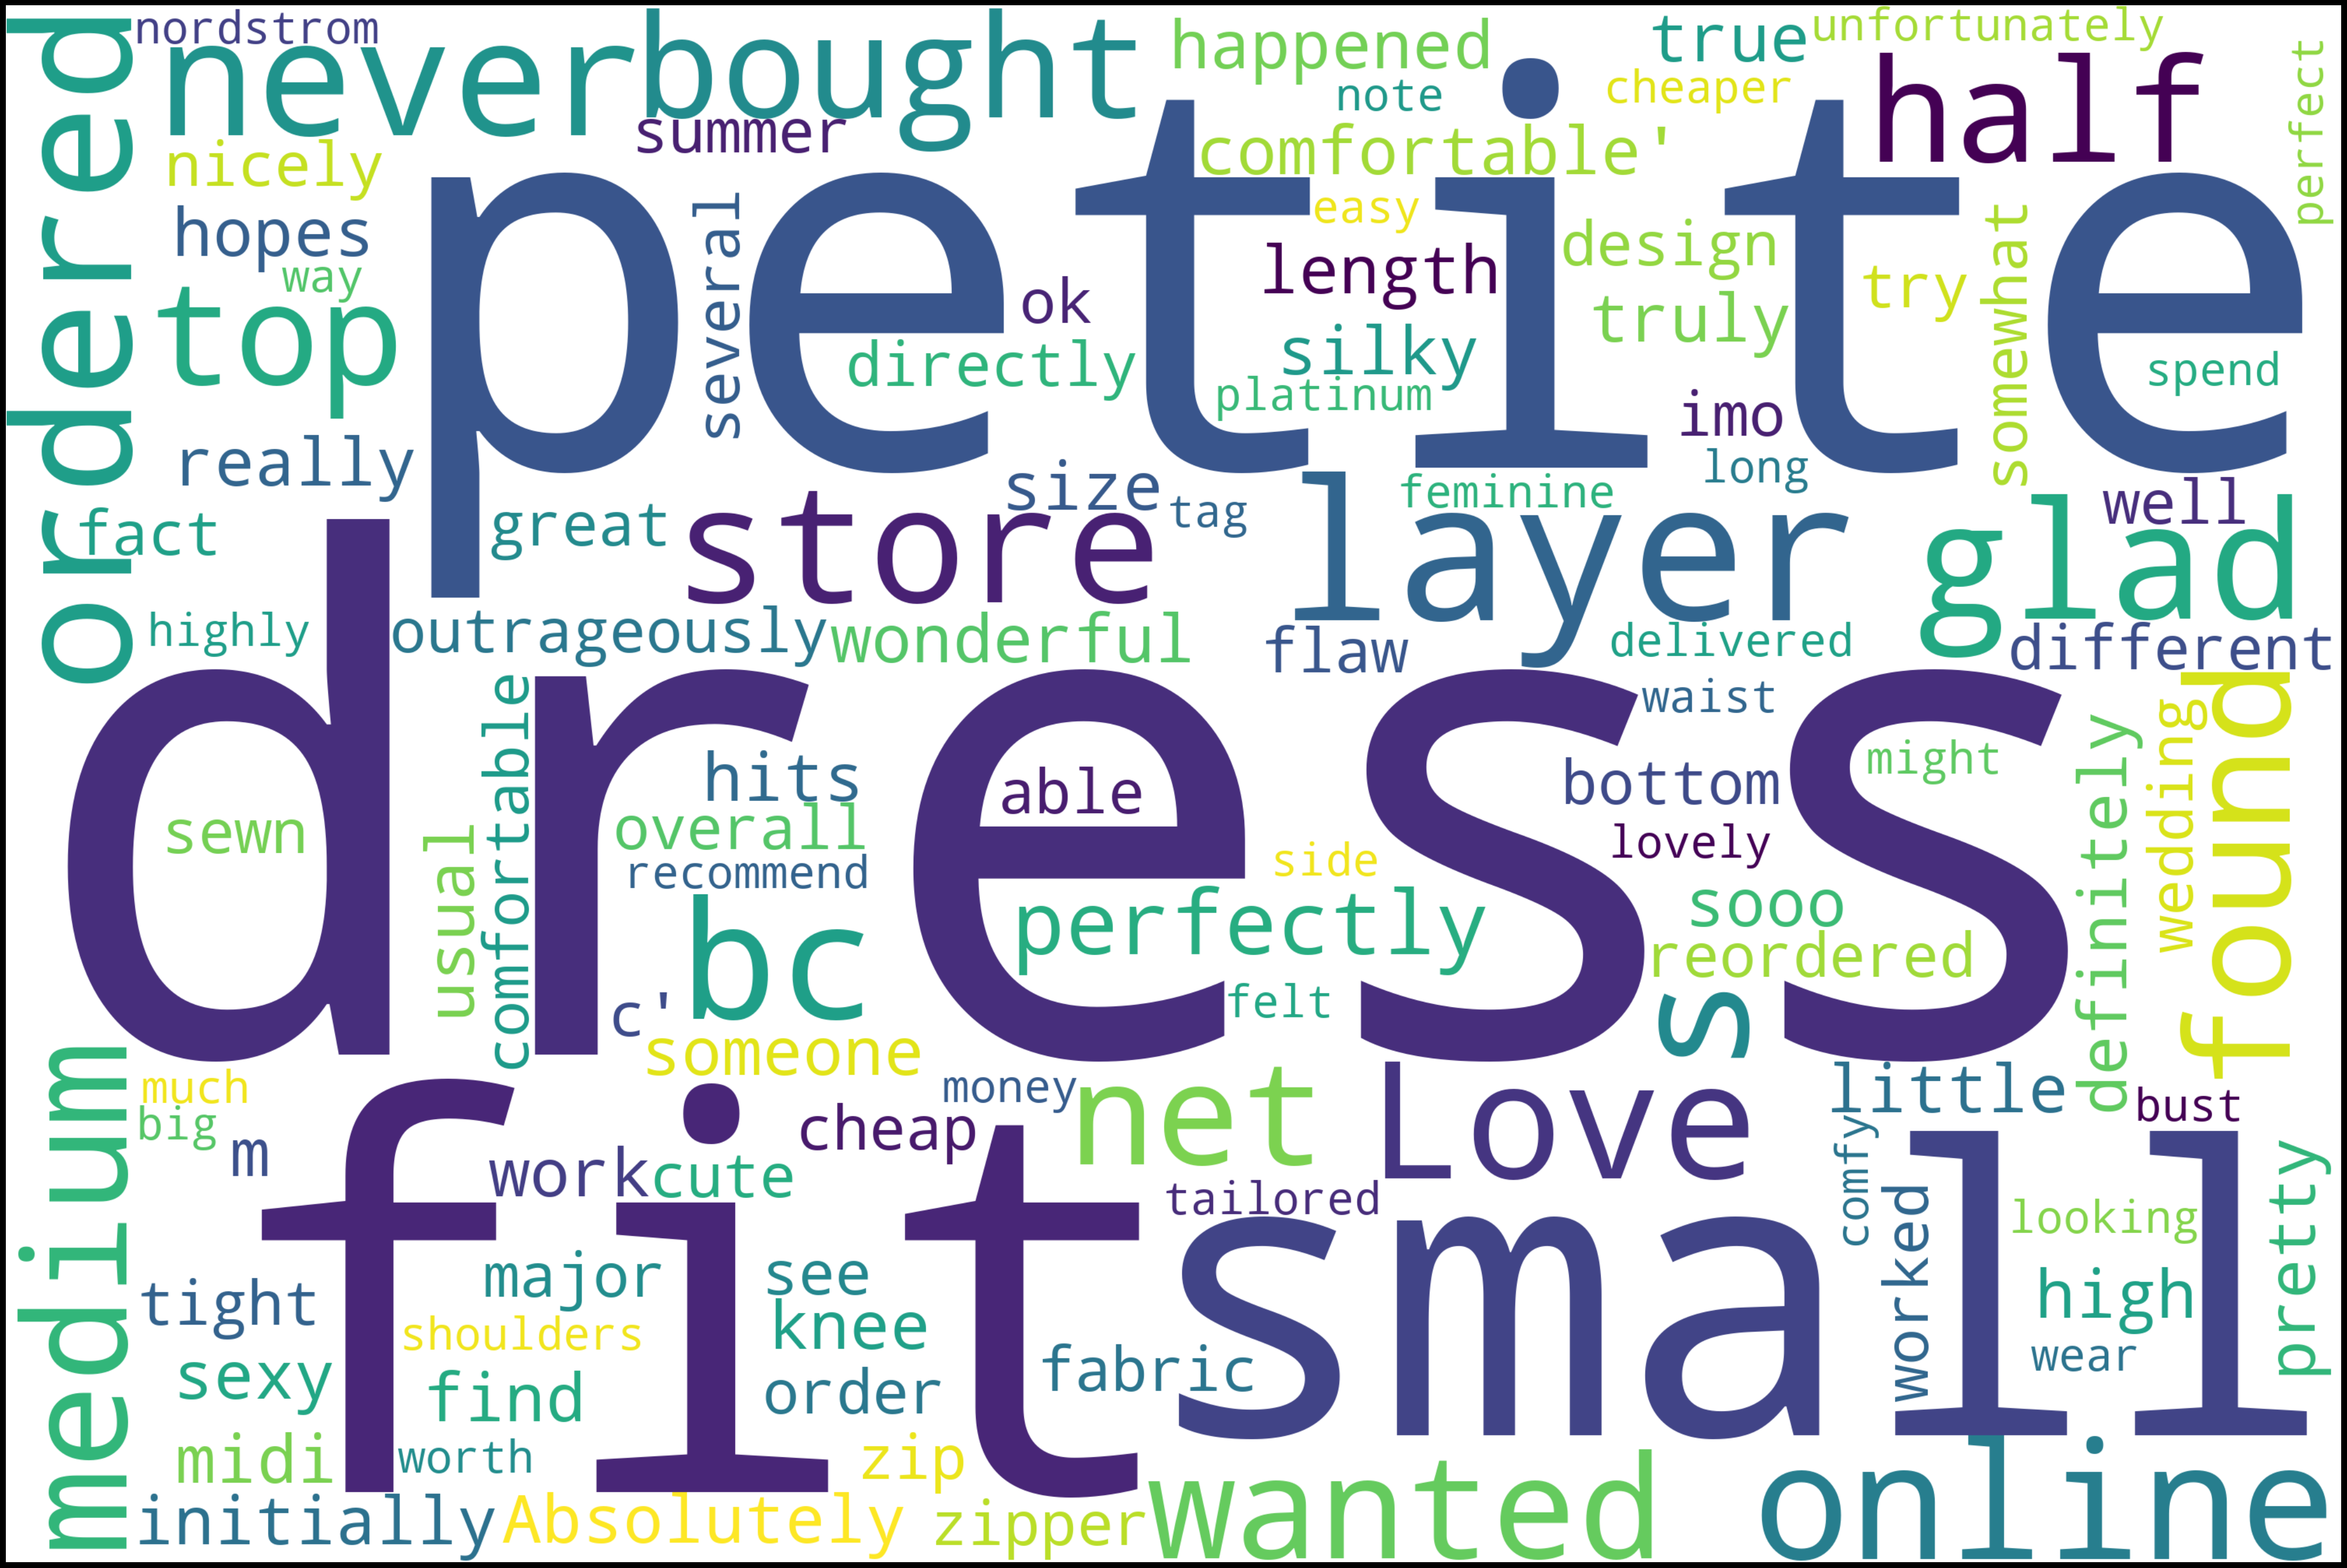

In [374]:
#word cloud of reviews
text = df['Review Text'].values

wordcloud = WordCloud(width=3000, height=2000, background_color='white', stopwords=STOPWORDS).generate(str(text))

plt.figure(figsize=(40, 30), facecolor='k', edgecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

<AxesSubplot: xlabel='Rating', ylabel='count'>

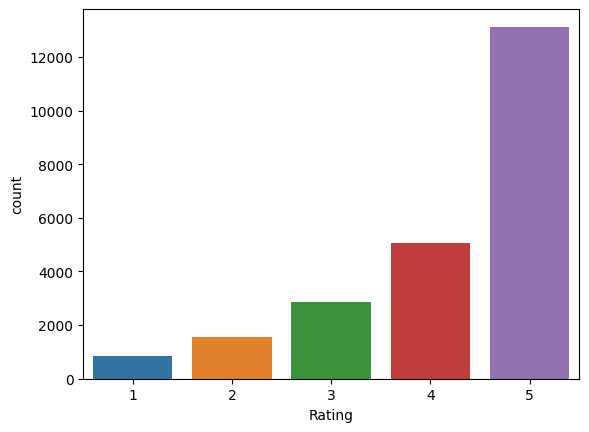

In [375]:
#the distribution of ratings
sns.countplot(x='Rating', data=df)


<AxesSubplot: xlabel='Recommended IND', ylabel='count'>

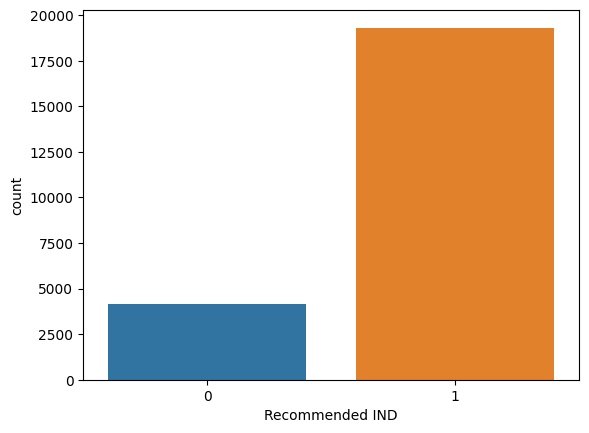

In [376]:
#recommended vs not recommended
sns.countplot(x='Recommended IND', data=df)



## data understanding

In [377]:
df.describe()

,Unnamed: 0,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


## feature engineering

In [378]:
df['Review Text'] = df['Title'] + ' ' + df['Review Text']
df = df.drop(['Title'], axis=1)

text_data = df['Review Text'].fillna('').str.lower().replace('[^a-z\s]', '', regex=True)

In [379]:
#remove stopwords and lemmatize
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

In [380]:
#fit the model
k = 5  
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

C:\Users\abakr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [381]:
cluster_analysis = df.groupby('cluster')['Review Text'].apply(lambda x: '\n'.join(x.dropna()) if x.dtype == 'O' else '').reset_index()
print(cluster_analysis)


   cluster                                        Review Text
0        0  Flattering shirt This shirt is very flattering...
1        1  Cagrcoal shimmer fun I aded this in my basket ...
2        2  My favorite buy! I love, love, love this jumps...
3        3  Some major design flaws I had such high hopes ...
4        4  Not for the very petite I love tracy reese dre...


In [382]:
#add cluster column to dataframe
df['cluster'] = kmeans.labels_
df.head()

,Unnamed: 0,Clothing ID,Age,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,cluster
0,0,767,33,NaN,4,1,0,Initmates,Intimate,Intimates,1
1,1,1080,34,NaN,5,1,4,General,Dresses,Dresses,1
2,2,1077,60,Some major design flaws I had such high hopes ...,3,0,0,General,Dresses,Dresses,3
3,3,1049,50,"My favorite buy! I love, love, love this jumps...",5,1,0,General Petite,Bottoms,Pants,2
4,4,847,47,Flattering shirt This shirt is very flattering...,5,1,6,General,Tops,Blouses,0


## first model

In [383]:
# Apply k-means clustering
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(tfidf_matrix)

C:\Users\abakr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [384]:

terms = vectorizer.get_feature_names_out()
# top terms for each cluster
for i in range(k):
    print("Cluster %d:" % i, end='')
    cluster_indices = order_centroids[i, :10]
    for ind in cluster_indices:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: love cute wore beautiful comfortable wash washed dry quality worth
Cluster 1: great love jeans perfect comfortable pants fit soft wear color
Cluster 2: like just fabric fit nice size cute color really look
Cluster 3: small size large runs medium ordered wear fit cute usually
Cluster 4: dress love beautiful size great fit wear perfect flattering just


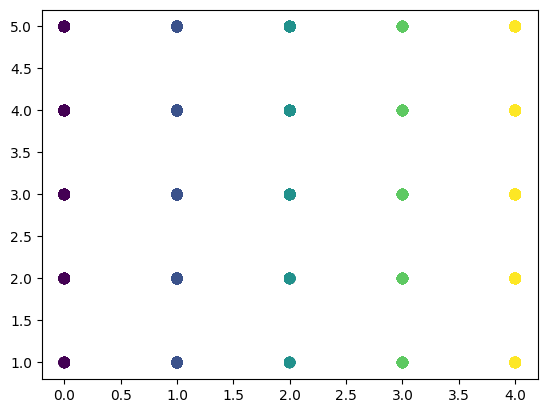

In [395]:
#plot the clusters
plt.scatter(df['cluster'], df['Rating'], c=clusters, s=50, cmap='viridis')

## clustering model evaluation

In [385]:
from sklearn.metrics import silhouette_score
predicted_clusters = kmeans.predict(tfidf_matrix)

# Silhouette Score
silhouette_avg = silhouette_score(tfidf_matrix, predicted_clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Inertia 
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")

        

Silhouette Score: -0.00046517096246518144
Inertia: 18727.103828956657


adding and extra model to make predictions random forest


In [386]:
df = pd.get_dummies(df, columns=['Department Name', 'Class Name','Division Name'], drop_first=True)

In [387]:
x = df.drop(['Recommended IND','Review Text'], axis=1)
y = df['Recommended IND']

In [388]:
x.head()

,Unnamed: 0,Clothing ID,Age,Rating,Positive Feedback Count,cluster,Department Name_Dresses,Department Name_Intimate,Department Name_Jackets,Department Name_Tops,...,Class Name_Outerwear,Class Name_Pants,Class Name_Shorts,Class Name_Skirts,Class Name_Sleep,Class Name_Sweaters,Class Name_Swim,Class Name_Trend,Division Name_General Petite,Division Name_Initmates
0,0,767,33,4,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1080,34,5,4,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1077,60,3,0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1049,50,5,0,2,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,4,847,47,5,6,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [389]:
train_x, test_x, train_y, test_y = train_test_split(x, y, random_state=4)
rf01 = RandomForestClassifier(n_estimators = 30,criterion="gini").fit(train_x,train_y)



In [390]:
prediction_rf01 = rf01.predict(train_x)
print(rf01.score(test_x,test_y))

0.9359673024523161


In [394]:
#evaluate the random forrest model
print(classification_report(train_y, prediction_rf01))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3099
           1       1.00      1.00      1.00     14515

    accuracy                           1.00     17614
   macro avg       1.00      1.00      1.00     17614
weighted avg       1.00      1.00      1.00     17614

